**Importing Libraries**


In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
device ='cpu'

In [ ]:
!pip install torch-snippets==0.495
from torch_snippets import *

**Dataset**

In [ ]:

df = pd.read_csv('metadata.csv')

train_df = df.loc[df['split'] == 'train']
tst_df = df.loc[df['split'] == 'test']
print("Training dataset size:", len(train_df))
print("Test dataset size:", len(tst_df))

In [ ]:
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

tfms = transforms.Compose([
#     transforms.RandomHorizontalFlip(0.3),
#     transforms.RandomRotation(40),
#     transforms.RandomVerticalFlip(0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # imagenet
                         [0.229, 0.224, 0.225])
])

class BuildingDataset(Dataset):
    def __init__(self, df, root=IMG_ROOT):
        self.df = df
        self.root = root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        w, h = 224, 224
        img_path = self.root+self.df.iloc[idx]['png_image_path']
        mask_path = self.root+self.df.iloc[idx]['png_label_path']
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        img = cv2.resize(img, (224, 224))
        mask = cv2.resize(mask, (224, 224))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        return img, mask

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images = torch.cat([tfms(img.copy()/255.)[None] for img in images]).float().to(device)
        masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return images, masks

tr_ds = BuildingDataset(train_df)
tst_ds = BuildingDataset(tst_df)

tr_dl = DataLoader(tr_ds, batch_size=4, drop_last=True, shuffle=True,
                  collate_fn=tr_ds.collate_fn)
tst_dl = DataLoader(tr_ds, batch_size=1, drop_last=True, shuffle=True,
                  collate_fn=tst_ds.collate_fn)

img, mask = tr_ds[10]
fig, ax = plt.subplots(1, 2)
show(img, ax=ax[0])
show(mask, ax=ax[1])

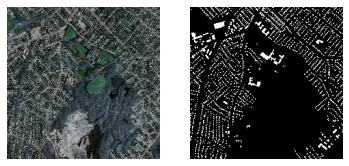

**Model**

In [ ]:
import torch.nn as nn
from torchvision.models import vgg16_bn

def conv(in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3,
                stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
     nn.ConvTranspose2d(in_channels, out_channels,
                         kernel_size=2, stride=2),
     nn.ReLU(inplace=True)
  )

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()
        self.backbone = vgg16_bn(pretrained=True).to(device).features
        self.down1 = nn.Sequential(*self.backbone[:6]) # 64
        self.down2 = nn.Sequential(*self.backbone[6:13]) # 128
        self.down3 = nn.Sequential(*self.backbone[13:20]) # 256
        self.down4 = nn.Sequential(*self.backbone[20:27]) # 512
        self.down5 = nn.Sequential(*self.backbone[27:34]) # 512

        self.bottleneck = nn.Sequential(*self.backbone[34:]) # 512
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv5 = up_conv(1024, 512)
        self.merge_conv5 = conv(512+512, 512)
        self.up_conv4 = up_conv(512, 256)
        self.merge_conv4 = conv(512 + 256, 256)
        self.up_conv3 = up_conv(256, 128)
        self.merge_conv3 = conv(256+128, 128)
        self.up_conv2 = up_conv(128, 64)
        self.merge_conv2 = conv(128+64, 64)
        self.up_conv1 = up_conv(64, 32)
        self.merge_conv1 = conv(32+64, 32)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # encoder
        x_1 = self.down1(x)
        x_2 = self.down2(x_1)
        x_3 = self.down3(x_2)
        x_4 = self.down4(x_3)
        x_5 = self.down5(x_4)
        # bottleneck
        x = self.bottleneck(x_5)
        x = self.conv_bottleneck(x)
        # decoder
        x = self.up_conv5(x)
        x = self.merge_conv5(torch.cat([x, x_5], dim=1))
        x = self.up_conv4(x)
        x = self.merge_conv4(torch.cat([x, x_4], dim=1))
        x = self.up_conv3(x)
        x = self.merge_conv3(torch.cat([x, x_3], dim=1))
        x = self.up_conv2(x)
        x = self.merge_conv2(torch.cat([x, x_2], dim=1))
        x = self.up_conv1(x)
        x = self.merge_conv1(torch.cat([x, x_1], dim=1))

        x = self.final_conv(x)
        return x

model = UNet().to(device)
model(torch.zeros((1, 3, 224, 224)).to(device))


tensor([[[[-0.3926, -2.4529, -0.5703,  ..., -1.0512, -1.5726, -2.2755],
          [-3.2240, -3.3825, -1.9989,  ..., -2.1209, -2.9966, -3.0140],
          [-0.8536, -4.7010, -0.8005,  ..., -1.4552, -1.6948, -2.1408],
          ...,
          [-1.6549, -3.4156, -0.5880,  ..., -1.2767, -1.8030, -3.2775],
          [-1.2390, -3.1418, -0.4083,  ..., -1.3878, -2.9231, -4.0419],
          [-2.0860, -2.9209, -1.3508,  ..., -2.1075, -2.8941, -5.2825]],

         [[-1.0293,  0.8786,  1.1708,  ...,  0.6153, -0.6985,  2.3501],
          [-0.6051, -4.1441, -2.9608,  ..., -2.6113, -4.3814, -3.0311],
          [-0.9404, -2.4478,  0.1204,  ..., -1.2253, -1.7230, -0.0714],
          ...,
          [-1.1704, -1.9986, -0.2153,  ..., -0.2163, -1.3208, -0.2265],
          [-0.2571, -1.5111, -0.1234,  ..., -1.6933, -1.2430, -1.4624],
          [-2.1285,  0.3880,  1.6500,  ...,  1.9368,  1.1316,  1.7972]],

         [[-0.6003, -3.2860, -1.7246,  ..., -2.4029, -0.7737, -0.9201],
          [ 3.1859,  2.0521,  2.7246,  ...,  2.7508,  5.1618,  1.6335],
          [ 1.1881, -1.2591, -0.2787,  ..., -0.6599,  2.3967,  1.1490],
          ...,
          [ 1.0666, -0.7162, -0.4287,  ...,  0.0731,  2.3881,  0.2906],
          [-0.0791, -1.7240, -0.2216,  ..., -0.3324,  2.7978,  2.8218],
          [ 2.3899, -0.2299,  0.1378,  ..., -0.1307,  1.1971,  0.3832]],

         ...,

         [[-0.1501, -2.7283,  0.1307,  ..., -0.5664, -0.9146, -3.8055],
          [-2.6406, -4.6637, -3.2022,  ..., -3.1269, -5.2034, -1.1422],
          [-1.0921, -3.1529, -0.1743,  ..., -1.0858, -3.5890, -1.8695],
          ...,
          [-2.0478, -2.1614, -0.6321,  ..., -0.3649, -3.7722, -1.4427],
          [-1.0151, -2.8372, -1.1381,  ..., -2.5757, -4.5189, -2.7211],
          [-1.5541, -1.3803, -0.7105,  ..., -0.7259, -4.0823, -1.7165]],

         [[ 2.3889,  2.3588,  1.2359,  ...,  1.8750,  0.5977,  1.6607],
          [ 1.8890,  3.4940,  1.2673,  ...,  1.4273,  0.2616,  0.3799],
          [-0.2821,  2.8403, -0.6177,  ...,  0.6916, -0.1258,  1.3706],
          ...,
          [ 0.1512,  2.2737,  0.7351,  ...,  0.5042, -0.5100,  0.2563],
          [-0.3069,  1.7971,  0.4414,  ...,  0.9625,  0.7819, -0.7817],
          [ 1.5147,  2.8215,  1.5958,  ...,  1.3670,  2.4758,  0.3600]],

         [[ 5.4193,  5.9477,  3.3766,  ...,  4.7607,  3.0575,  2.3578],
          [ 6.7948,  6.6650,  4.2261,  ...,  3.6183,  5.0259,  4.0921],
          [ 3.9396,  4.7811, -0.5918,  ...,  0.9574,  0.6267,  1.7256],
          ...,
          [ 4.6504,  4.9334,  0.4813,  ...,  1.4626, -0.0580,  2.6433],
          [ 4.9706,  3.3990, -0.0802,  ...,  1.3050, -0.5754,  1.4486],
          [ 5.0695,  4.6917,  1.4307,  ...,  2.1936,  0.8641,  2.4718]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

Training

In [ ]:
def loss_fn(preds, targets):
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return loss, acc

def train_batch(model, batch, optim, loss_fn):
    model.train()
    imgs, masks = batch
    pred_masks = model(imgs)
    optim.zero_grad()
    loss, acc = loss_fn(pred_masks, masks)
    loss.backward()
    optim.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, batch, loss_fn):
    model.eval()
    imgs, masks = batch
    pred_masks = model(imgs)
    loss, acc = loss_fn(pred_masks, masks)
    return loss.item(), acc.item()

model = UNet(out_channels=300).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = loss_fn
n_epochs = 50
log = Report(n_epochs)
for e in range(n_epochs):
    N = len(tr_dl)
    for i, batch in enumerate(tr_dl):
        loss, acc = train_batch(model, batch, optim, loss_fn)
        log.record(e+(i+1)/N, trn_loss=loss, trn_acc=acc, end='\r')
    N = len(tst_dl)
    for i, batch in enumerate(tst_dl):
        loss, acc = validate_batch(model, batch, loss_fn)
        log.record(e+(i+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(e+1)

In [ ]:
log.plot_epochs(['trn_loss', 'val_loss'])

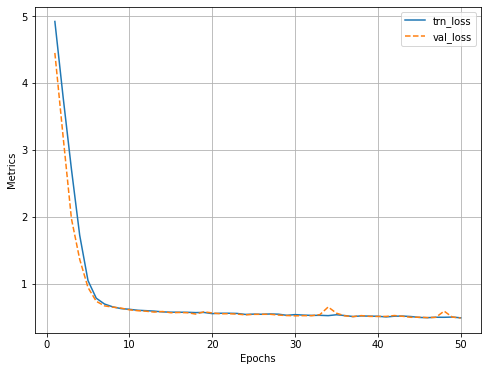

Testing

In [ ]:
im, mask = next(iter(tst_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])

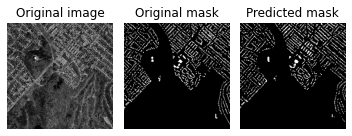